In [19]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dill as pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange
import bayesnewton
from scipy.cluster.vq import kmeans2
import objax
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
def load_data(pollutant, data_path="data/", time_step=None, time_range=None, season=None, day_of_week=None, time_of_day=None, noisy=False, decimals=6):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param time_step: if provided, {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive
            If second element isn't provided, defaults to present day
    :param season: true, false - creates columns for each seasons denoted by binary columns to the season datapoint belongs to
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param day_of_week: true, false
            0 : weekday
            1 : weekend
    :param time_of_day: true, false
            0 : daytime
            1 : nighttime
    """
    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    df = df.loc[df[pollutant.lower()] > 0]
    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if time_step in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(time_step).mean().dropna()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[time_step]))

    df = df.reset_index()
    # seasonal buckets
    # creates binary column for each season 
    # (1 represents that the data point is part of that season, 0 represents not part of season)
    if season:
        seasons = {"winter": [12, 1, 2], 
                "spring": [i for i in range(3, 6)], 
                "summer" : [i for i in range(6, 9)], 
                "autumn" : [i for i in range(9, 12)]}

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        
        for s in seasons:
            # condition = (df.Month in seasons[season])
            condition = ((df.Month >= seasons[s][0]) & (df.Month <=seasons[s][-1]))
            if s == "winter":
                condition = ((df.Month >= seasons[s][0]) | (df.Month <= seasons[s][-1]))
            df[s] = np.where(condition, 1, 0)

        # drop created month column
        df = df.drop(["Month"], axis=1)
        
    # day of week buckets: weekday vs weekend
    # creates binary column for 'day_of_week' (1 represents weekday, 0 represents weekend)
    if day_of_week:
        weekdays = [i for i in range(5)]
        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek
        # condition = (df.DayOfWeek in weekdays)
        condition = ((df.DayOfWeek >= weekdays[0]) & (df.DayOfWeek <= weekdays[-1]))

        # add binary column denoting whether data point belongs to input day of week group
        df['day_of_week'] = np.where(condition, 1, 0)
        df = df.drop(["DayOfWeek"], axis=1)
        
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    # creates binary column for 'time_of_day' (1 represents daytime, 0 represents nighttime)
    if time_of_day:
        daytime_hours = [i for i in range(7, 18)]
        df["Hour"] = pd.DatetimeIndex(df['date']).hour
        # condition = (df.Hour in daytime_hours)

        condition = ((df.Hour >= daytime_hours[0]) & (df.Hour <= daytime_hours[-1]))
        if time_of_day == "night":
            condition = ((df.Hour >= daytime_hours[0]) | (df.Hour <= daytime_hours[-1]))

        df["time_of_day"] = np.where(condition, 1, 0)
        df = df.drop(["Hour"], axis=1)

    # generate time_step (t) column
    df = df.sort_values("date")
    dates = df["date"].values

    t = -1
    current_date = None
    time_steps = []
    for date in dates:
        if date != current_date:
            t += 1
            current_date = date
        time_steps.append(t)
    df["t"] = time_steps
    
    df["latitude"] = df["latitude"].round(decimals)
    df["longitude"] = df["longitude"].round(decimals)
        
    if noisy:
        n = df.shape[0]
        lat_noise, lon_noise = np.random.normal(0,10**(-decimals),n), np.random.normal(0,10**(-decimals),n)
        df["latitude"] = df["latitude"] + lat_noise
        df["longitude"] = df["longitude"] + lon_noise
    
    return df

In [3]:
def split_data(df, test_percent=0.2, validation_sites=[]):
    """
    returns: train_df, test_df, validation_df
    """
    val_df = df[df["code"].isin(validation_sites)].copy()
    model_df = df[~df["code"].isin(validation_sites)].copy()
    N, M = model_df.shape
    indices = np.arange(N)
    train_indices, test_indices = train_test_split(indices, test_size=test_percent)
    train_df, test_df = model_df.iloc[train_indices, :].copy(), model_df.iloc[test_indices, :].copy()
    return train_df, test_df, val_df

In [4]:
def scale_data(train_df, test_df, val_df, features):
    scalers = {}
    for feature in features:
        scaler = StandardScaler()
        train_df[f"scaled_{feature}"] = scaler.fit_transform(train_df[[feature]].values)
        test_df[f"scaled_{feature}"] = scaler.transform(test_df[[feature]].values)
        if val_df.shape[0] > 0:
            val_df[f"scaled_{feature}"] = scaler.transform(val_df[[feature]].values)
        scalers[feature] = scaler
    return scalers

In [5]:
def train_model(train_df, x_features, y_features):
    X = train_df[x_features].values
    Y = train_df[y_features].values
    t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
    Nt = t.shape[0]
    print("num time steps =", Nt)
    Nr = R.shape[1]
    print("num spatial points =", Nr)
    N = Nt * Nr
    print("num data points =", N)

    var_y = 5.
    var_f = 1.
    len_time = 0.01
    len_space = 0.2

    num_z_space = 30
    sparse = True
    opt_z = sparse

    z = kmeans2(R[0, ...], num_z_space, minit="points")[0]

    kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
    kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
    kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
    kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

    kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                    spatial_kernel=kern_space,
                                                    z=z,
                                                    sparse=sparse,
                                                    opt_z=opt_z,
                                                    conditional='Full')

    lik = bayesnewton.likelihoods.Gaussian(variance=var_y)

    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y, parallel=False)

    lr_adam = 0.01
    lr_newton = 1.
    iters = 300
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E

    train_op = objax.Jit(train_op)
    
    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        print('iter %2d: energy: %1.4f' % (i, loss[0]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    avg_time_taken = (t1-t0)/iters
    print('average iter time: %2.2f secs' % avg_time_taken)

    return model

In [50]:
def test_model(model, test_df, x_features, y_features):
    X_test = test_df[x_features].values
    Y_test = test_df[y_features].values
    t_test, R_test, Y_test = bayesnewton.utils.create_spatiotemporal_grid(X_test, Y_test)
    test_mean, test_var = model.predict_y(X=t_test, R=R_test)
    nlpd = model.negative_log_predictive_density(X=t_test, R=R_test, Y=Y_test)
    rmse = np.sqrt(np.nanmean((np.squeeze(Y_test) - np.squeeze(test_mean))**2))
    print('nlpd: %2.3f' % nlpd)
    print('rmse: %2.3f' % rmse)

    return test_mean, test_var, nlpd, rmse

In [7]:
def save_model(filename, df, model, train_df, test_df, val_df, train_scalers):
    path = f"GPR-models/ST-SVGP/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    df_filename = f"{path}{filename}_df.sav"
    model_filename = f"{path}{filename}_model.sav"
    train_df_filename = f"{path}{filename}_train_df.sav"
    test_df_filename = f"{path}{filename}_test_df.sav"
    val_df_filename = f"{path}{filename}_validation_df.sav"
    scalers_filename = f"{path}{filename}_scalers.sav"
    pickle.dump(df, open(df_filename, "wb"))
    pickle.dump(model, open(model_filename, "wb"))
    pickle.dump(train_df, open(train_df_filename, "wb"))
    pickle.dump(test_df, open(test_df_filename, "wb"))
    pickle.dump(val_df, open(val_df_filename, "wb"))
    pickle.dump(train_scalers, open(scalers_filename, "wb"))

In [8]:
def load_model(filename):
    path = f"GPR-models/ST-SVGP/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    val_df = pickle.load(open(f"{path}_val_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, val_df, scalers

In [53]:
def plot_site(model, df, code, x_features, y_features, scalers, title="Predictions after training", save=False, save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    t_plot = np.linspace(min_t, max_t, max_t-min_t+1).reshape(-1, 1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    site_lat, site_lon = df.loc[df['code'] == code]['latitude'].unique()[0], df.loc[df['code'] == code]['longitude'].unique()[0]
    scaled_lat = np.asscalar(scalers['latitude'].transform(np.array([[site_lat]])))
    scaled_lon = np.asscalar(scalers['longitude'].transform(np.array([[site_lon]])))
    R_plot = np.tile(np.array([[scaled_lat, scaled_lon]]), [t_plot.shape[0], 1, 1])

    plt.figure()
    plt.subplots(facecolor="white")

    # PLOT PREDICTION WITH VARIANCE
    prediction_mean, prediction_std = model.predict_y(X=t_plot, R=R_plot)
    prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
    (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
    plt.fill_between(
        dates,
        prediction_mean-1.96*prediction_std,
        prediction_mean+1.96*prediction_std,
        color=line.get_color(),
        alpha=0.6,
        label=r"95% confidence interval"
    )
    
    # PLOT ACTUAL VALUES
    Y_true = df[y_features]
    plt.plot(dates, Y_true, "x", label="Validation points", alpha=0.9, color="red")

    # GET RMSE
    rmse = np.sqrt(np.nanmean((np.squeeze(Y_true) - np.squeeze(prediction_mean))**2))

    plt.title(f"{title} for site {code}\nRMSE: {rmse}")
    plt.xlabel(f"Date")
    plt.ylabel(f"Concentration of NO2 (ug/m3)")
    
    plt.gcf().autofmt_xdate()

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.legend(loc=(1.04,0))

    if save:
        plt.savefig(fname=save_path + "prediction_" + code + ".png")
    plt.show()

In [9]:
"""
SPECIFY DATA PARAMETERS
"""
pollutant = "NO2"
time_step = "D"
time_range = (datetime(2011, 9, 1), datetime(2011, 12, 31))
season = False
day_of_week = False
time_of_day = False
noisy = False
decimals = 6

random_id = random.randint(0, 10000)
filename = figure_title = f"STSVGP_MODEL_{random_id}"

In [8]:
alex_data_path = "../../data/"
ana_data_path = "../data-collection/LAQN_API_data/"
df = load_data(pollutant, data_path=alex_data_path, time_step=time_step, time_range=time_range, season=season, day_of_week=day_of_week, time_of_day=time_of_day, noisy=noisy, decimals=decimals)

In [9]:
df.head()

,code,date,nox,no2,latitude,longitude,t
0,BG1,2011-09-01,30.239181,23.962734,51.563752,0.177891,0
7543,RB1,2011-09-01,35.915554,25.774858,51.569221,0.081821,0
737,BT5,2011-09-01,59.601210,26.168211,51.552656,-0.248774,0
7421,NM3,2011-09-01,52.068643,35.024095,51.514727,0.014554,0
7307,NM2,2011-09-01,68.886440,42.984811,51.537598,-0.002138,0


In [43]:
validation_sites = ["HK6"]
train_df, test_df, validation_df = split_data(df, validation_sites=validation_sites)

In [47]:
scaled_features = ["latitude", "longitude"]
scalers = scale_data(train_df, test_df, validation_df, scaled_features)

In [9]:
"""
LOAD MODEL
"""
filename = "STSVGP_MODEL_6040"
model, df, train_df, test_df, val_df, scalers = load_model(filename)

In [10]:
x_features = ["t", "scaled_latitude", "scaled_longitude"]
y_features = ["no2"]

In [ ]:
model = train_model(train_df, x_features, y_features)

In [11]:
test_mean, test_var, test_nlpd, test_rmse = test_model(model, test_df, x_features, y_features)

nlpd: 45.833
rmse: 28.334


In [12]:
val_mean, val_var, val_nlpd, val_rmse = test_model(model, val_df, x_features, y_features)

nlpd: 8.696
rmse: 10.873


In [62]:
save_model(filename, df, model, train_df, test_df, val_df, scalers)

In [13]:
grid_size = 50
# t_plot = np.linspace(df['t'].min(), df['t'].max(), num=df['t'].max()-df['t'].min()+1).reshape(-1, 1)
t_plot = np.linspace(0, 9, num=10).reshape(-1, 1)
lat_plot = np.linspace(df['latitude'].min(), df['latitude'].max(), num=grid_size).reshape(-1, 1)
lon_plot = np.linspace(df['longitude'].min(), df['longitude'].max(), num=grid_size).reshape(-1, 1)
LAT, LON = np.meshgrid(lat_plot, lon_plot)

In [25]:
scaled_lat_plot = scalers['latitude'].transform(lat_plot).flatten()
scaled_lon_plot = scalers['longitude'].transform(lon_plot).flatten()
r1_plot, r2_plot = [], []
for i in range(grid_size):
    for j in range(grid_size):
        r1_plot.append([scaled_lat_plot[i]])
        r2_plot.append([scaled_lon_plot[j]])
r1_plot, r2_plot = np.array(r1_plot), np.array(r2_plot)
R_plot = np.tile(np.hstack((r1_plot, r2_plot)), [t_plot.shape[0], 1, 1])

In [15]:
pred_mean, pred_var = model.predict_y(X=t_plot, R=R_plot)

In [16]:
pred_mean_plot = np.mean(pred_mean, axis=0).reshape(grid_size, grid_size)
pred_var_plot = np.mean(pred_var, axis=0).reshape(grid_size, grid_size)

In [20]:
map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp"
map_df = gpd.read_file(map_filepath)
map_df = map_df.to_crs("EPSG:4326")
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33066 51.32901, -0.33057 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30843 51.37586, -0.30832 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30383 51.39249, -0.30373 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26988 51.38845, -0.26973 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24660 51.39921, -0.24670 51.39920..."


In [22]:
z_opt = model.kernel.z.value
z_lat = scalers['latitude'].inverse_transform(z_opt[:, 0].reshape(-1, 1))
z_lon = scalers['longitude'].inverse_transform(z_opt[:, 1].reshape(-1, 1))

<AxesSubplot:>

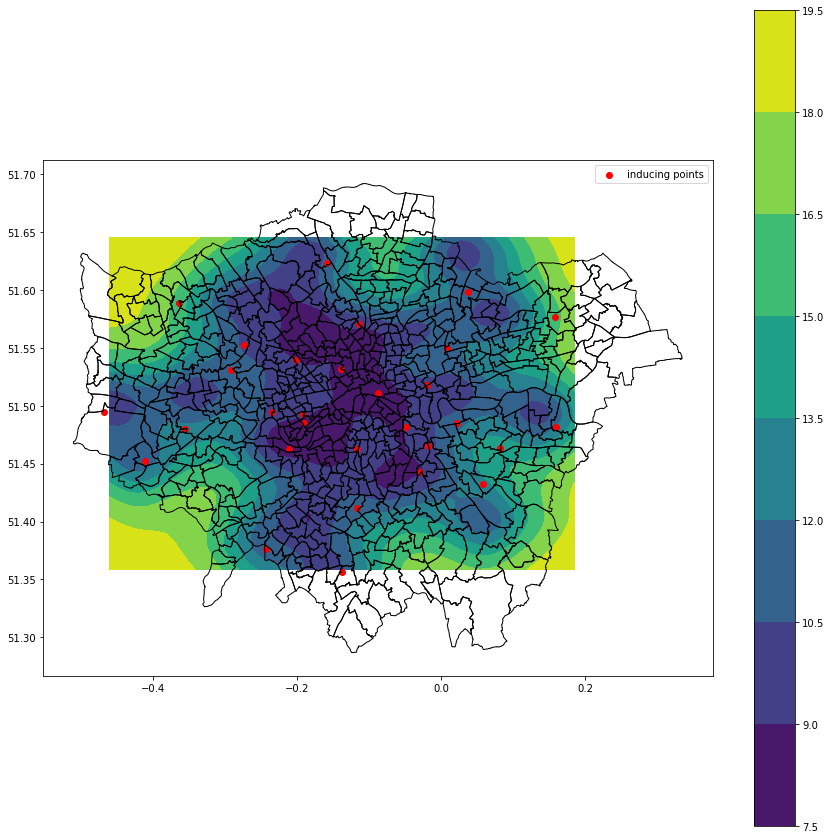

In [23]:
fig, ax = plt.subplots(figsize=(15,15))

plt.contourf(LON, LAT, pred_var_plot)# norm=normi, extend='both')
plt.colorbar()

plt.scatter(z_lon, z_lat, label="inducing points", color="red")
plt.legend()

ax.set_facecolor('white')
map_df.plot(ax=ax, color="None")

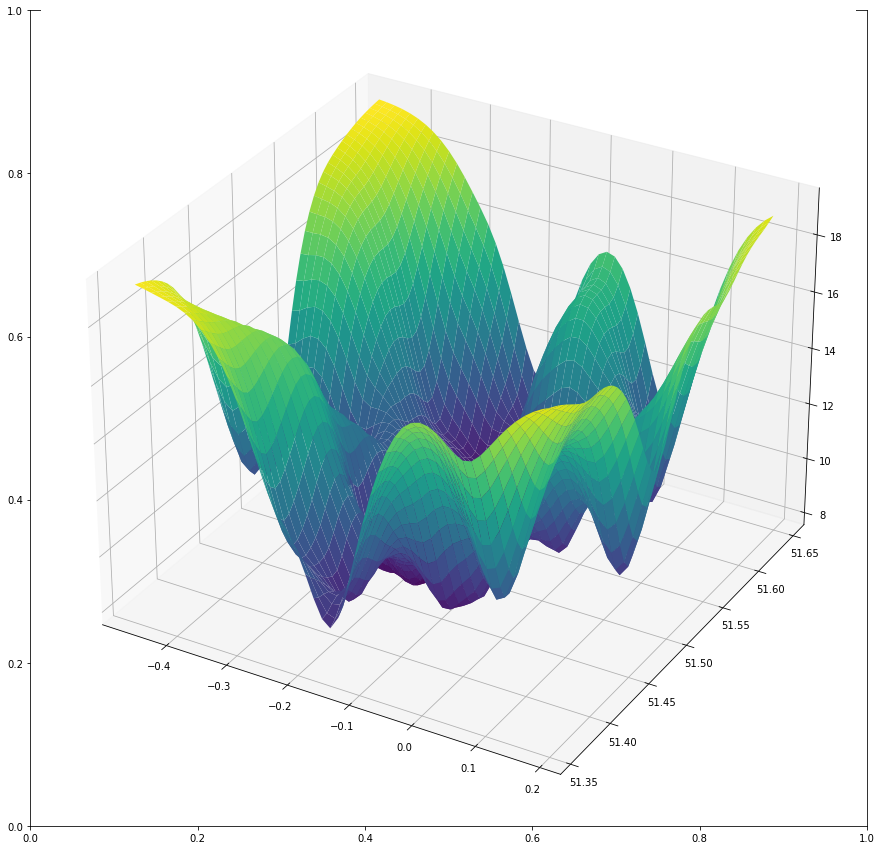

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

ax = plt.axes(projection='3d')
ax.plot_surface(LON, LAT, pred_var_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

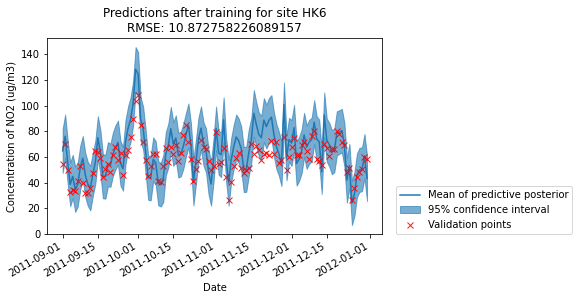

In [54]:
plot_site(model, val_df, "HK6", x_features, y_features, scalers)